# Feature Engineering, Decision Tree Pruning and Hyperparameter Tuning

### The Data
We will be using the dataset <em>incidents.csv</em>. 

This dataset contains 5000 cases and 13 features, including:

- city_name
- magnitude_of_delay
- delay_in_seconds
- affected_roads
- record_date
- luminosity
- avg_temperature
- avg_atm_pressure
- avg_humidity
- avg_wind_speed
- avg_precipitation
- avg_rain
- incidents

## Import Libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

## Get the data

We'll use the built in hotel bookings dataset from Scikit Learn. We can get with the load function:

In [86]:
#treino
#ler os datasets
ener21 = pd.read_csv("competicao/energia_202109-202112.csv", encoding='latin-1')
ener22 = pd.read_csv("competicao/energia_202201-202212.csv", encoding='latin-1')
meteo21 = pd.read_csv("competicao/meteo_202109-202112.csv", encoding='latin-1')
meteo22 = pd.read_csv("competicao/meteo_202201-202212.csv", encoding='latin-1')
##################### Merge de energia e metereologia ####################################
#criar uma coluna para conseguir dar merge
ener21['DateKey'] = pd.to_datetime(ener21['Data'] + ' ' + ener21['Hora'].astype(str) + ':00:00')
meteo21['DateKey'] = pd.to_datetime(meteo21['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC')
ener22['DateKey'] = pd.to_datetime(ener22['Data'] + ' ' + ener22['Hora'].astype(str) + ':00:00')
meteo22['DateKey'] = pd.to_datetime(meteo22['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC')
#dar merge
energia21 = pd.merge(ener21, meteo21, on=["DateKey"])
energia22 = pd.merge(ener22, meteo22, on=["DateKey"])
#remover as colunas não necessárias
energia21.drop(['Data', 'Hora', 'dt_iso'], axis=1, inplace=True)
energia22.drop(['Data', 'Hora', 'dt_iso'], axis=1, inplace=True)
##################### Concat do dataset 21 com o dataset 22 ####################################
energia_total = pd.concat([energia21, energia22], axis=0)
#teste
data = pd.read_csv("competicao/energia_202301-202304.csv", encoding='latin-1')
data = pd.read_csv("competicao/meteo_202301-202304.csv", encoding='latin-1')

In [87]:
energia_total.columns

Index(['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)',
       'Injeção na rede (kWh)', 'DateKey', 'dt', 'city_name', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'sea_level',
       'grnd_level', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all',
       'weather_description'],
      dtype='object')

<Axes: >

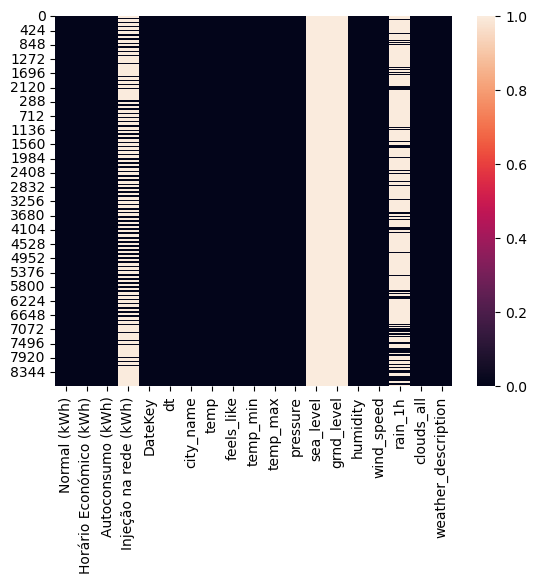

In [88]:
sns.heatmap(energia_total.isnull(),)

In [89]:
energia_total.head()

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),DateKey,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,0.0,0.0,0.0,NaN,2021-09-29 00:00:00,1632873600,local,13.97,13.54,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,0.0,0.0,0.0,NaN,2021-09-29 01:00:00,1632877200,local,13.48,13.02,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,0.0,0.0,0.0,NaN,2021-09-29 02:00:00,1632880800,local,12.93,12.47,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,0.0,0.0,0.0,NaN,2021-09-29 03:00:00,1632884400,local,12.61,12.15,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,0.0,0.0,0.0,NaN,2021-09-29 04:00:00,1632888000,local,12.61,12.17,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds


# Handling missing data and possible data transformations
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

## 1. Missing Values

In [90]:
energia_total.drop(['sea_level', 'grnd_level'], axis=1, inplace=True)
print(energia_total.isna().sum())

Normal (kWh)                  0
Horário Económico (kWh)       0
Autoconsumo (kWh)             0
Injeção na rede (kWh)      7777
DateKey                       0
dt                            0
city_name                     0
temp                          0
feels_like                    0
temp_min                      0
temp_max                      0
pressure                      0
humidity                      0
wind_speed                    0
rain_1h                    8732
clouds_all                    0
weather_description           0
dtype: int64


<Axes: >

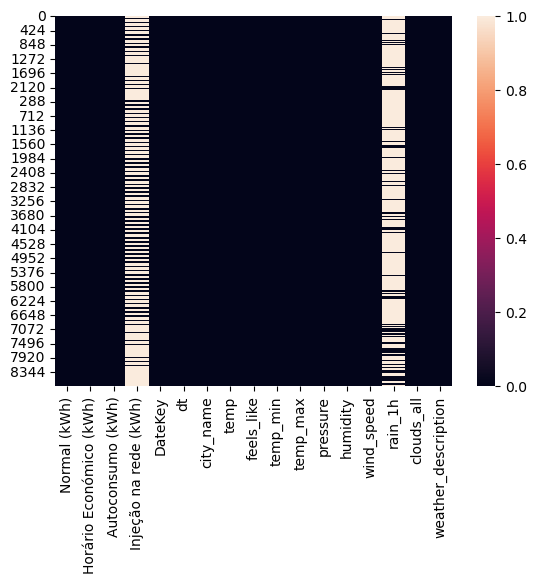

In [91]:
sns.heatmap(energia_total.isnull(),)

### - Drop or fill
Let's verify how the data is presented in the feature <em>affected_roads</em>

In [92]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(energia_total[['Injeção na rede (kWh)	']])

# Create a DataFrame with one-hot encoded data
one_hot_df = energia_total.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Injeção na rede (kWh)	']))
sns.heatmap(energia_total.isnull(),)

KeyError: "None of [Index(['Injeção na rede (kWh)\\t'], dtype='object')] are in the [columns]"

Copy of the data to experiment the options

#### a) Drop

#### b) Fill with zero

We need to choose one of the options to keep going. We will choose to drop the column since it does not bring added value to our goal.

Let's see if there are still missing values

There are features that are of the type <em>object</em>: <em>city_name</em>, <em>magnitude_of_delay</em>, <em>record_date</em>, <em>luminosity</em>, <em>avg_rain</em> and <em>incidents</em>.

Let's see how many different values each feature has.

The features <em>city_name</em> and <em>avg_precipitation</em> have only one value. We will start with <em>avg_precipitation</em>:

Since 0 is the unique value of <em>avg_precipitation</em> and all entries have the same value, we will drop this feature.

## 2. Handling categoric data

Feature <em>city_name</em>

The unique value of <em>city_name</em> is <em>Guimarães</em>. We can drop this feature as well.

Let's see the feature <em>incidents</em>:

Let's create a barplot of <em>Frequency Distribution of Incidents</em> (style="darkgrid", fontsize=12)

Let's create a pie plot of <em>Category Distribution of Incidents</em>

We have several options how to deal with qualitative data:

#### a) Replace Values

Again, we are using data copies to experiment all options.

We need to create a dictionary assigning the string to a numeric value:

None - 0, Low - 1, Medium - 2, High - 3, Very_High - 4

Then we create the labels and associate:

Now we need to replace with the new values:

Done! Now we can see that the type of values are <em>int64</em>:

#### b) Label encoding

Similar to the previous examples, each string will be assigned a number. Instead of replacing the values under the column <em>incidents</em>, we are going to create a new colum to each created label.

To complete the process, it is needed to replicate for each label and then drop the column <em>incidents</em>.

Let's see another way to label encoding. This uses the <em>LabelEncoder</em> from <em>sklearn</em>.

It creates a new column, <em>incidents_code</em>, with the labels assigned to feature <em>incidents</em>. The numeric values were assigned randomly, being the crescent order not apllicable to the meaning of the qualifying words.

#### c) One-Hot encoding

This alternative uses <em>LabelBinarizer</em> of <em>sklearn</em> and creates a matrix with bits regarding each label.

#### d) Binary Encoding
Similar to the previous technique, it creates a matrix of the status of the values, but this time with binary values. See the comparison between techniques below:

|   Level   | "Decimal encoding" | Binary encoding | One-Hot encoding |
| :-------: | :----------------: | :-------------: | :--------------: |
| None      |         0          |       000       |      000001      |
| Low       |         1          |       001       |      000010      |
| Medium    |         2          |       010       |      000100      |
| High      |         3          |       011       |      001000      |
| Very_High |         4          |       100       |      010000      |

For this technique it is needed to have the <em>category_encoders</em> installed:
<code>!pip install category_encoders</code>

#### e) Backward difference encoding
The values are normalized in the range of -1 to 1.

#### f) Factorize
This technique encodes the object as an enumerated type or categorical variable.

We will choose the factorize technique to keep going.

Regarding the features <em>magnitude_delay</em>, <em>luminosity</em> and <em>avg_rain</em>, we will factorize for now.

## 3. Handling dates

Datetime Properties and Methods (https://pandas.pydata.org/pandas-docs/version/0.23/api.html#datetimelike-properties)

We are going to convert the dates from <em>object</em> to <em>datetime</em>, specifying the format we want:

We can extract parts of the date and create newm columns with that:

Since the year and the minute have only one value, we will drop it.

Other functions to deal with dates

We can use <em>datetime.today</em> and fetch the actual date.

It can be measured the time elapsed between the dates on the dataset and today.

And we can also separate each component of the date by day, month, hour, time, etc.

Now we need to choose how to deal with the <em>record_date</em>.

There are other features that need to be worked on, but it's up to you now!

# Exploratory Data Analysis

Time to put your data viz skills to the test! Try to recreate the following plots, make sure to import the libraries you'll need!

Let's analyze through a heatmap

We can see that there is a relation between 
- <em>magnitude_of_delay</em> and <em>delay_in_seconds</em>
- <em>magnitude_of_delay</em> and <em>record_date</em>
- <em>avg_humidity</em> and <em>luminosity<em>

Let's see with a pairplot

It's hard to analyze the relation of all features. Let's create jointplots between the features with notice a relationship.

Jointplot of <em>Magnitude_of_delay vs. Delay_in_seconds</em>

Jointplot <em>Luminosity vs. Avg_temperature</em>

Jointplot <em>Avg_humidity vs. Delay_in_seconds</em>

Jointplot <em>Avg_temperature vs. Avg_humidity</em>

It seems there are a relation between <em>Avg_temperature</em> and <em>Avg_humidity</em>. Let´s create a lmplot <em>Avg_temperature vs. Avg_humidity</em>

# Train Test Split

Split the data into a training set and a testing set.

# Train a Model

Now it's time to train a Decision Tree Classifier. 

**Call the DecisionTreeClassifier() model from sklearn and fit the model to the training data.**

#### 1. Plot the resultant tree (plot_tree) and save it as figure (.png)

#### 2. Using export_text to represent the tree. Save it in a log file

# Model Evaluation

Now let's get predictions from the model and create a confusion matrix and a classification report.

Let's see if we can tune the parameters to try to get even better. It is unlikely, and you probably would be satisfied with these results in real like because the data set is quite small, but I just want you to practice using GridSearch.

## Gridsearch Practice

- Finding the right parameters is a tricky task
- The idea of creating a 'grid' of parameters and trying out all the possible combinations is called a Gridsearch
    - This method is common enough that Scikit-learn has this functionality built in with GridSearchCV (CV stands for Cross-Validation)
    - GridSearchCV takes a dictionary that describes the parameters that should be tried and the model to train
    - The grid of parameters is defined as a dictionary where the keys are the parameters and the values are the settings to be tested

- GridSearchCV is a meta-estimator
- It takes an estimator like DTC and creates a new estimator that behaves exactly the same - in this case, like a classifier.
- You should add <em>refit=True</em> and choose verbose to whatever number you want (verbose means the text output describing the process).

What does fit do: 
- Runs the same loop with cross-validation to find the best parameter combination 
- Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation) to built a single new model using the best parameter setting

Now let's take that grid model and create some predictions using the test set and create classification reports and confusion matrices for them. Were you able to improve?

## Pruning

Pruning of the DT is done by replacing a whole subtree by a leaf node.
If the expected error rate in the subtree is greater thant the single leaf,  it is made the replacement.

When to apply in Decision Trees:
- If the node gets very small, do not continue to split
- Minimum error (cross-validation) pruning without early stopping is a good technique
- Build a full-depth tree and work backward by applying a statistical test during each stage
- Prune an interior node and raise the sub-tree beneath it up one level

#### Best Depth Tree

You can inspect the best parameters found by GridSearchCV in the **best_params_ attribute**, and the best estimator in the **best\_estimator_ attribute**:

#### 1. Plot the tree (dpi=1000)

#### 2. Evaluate the model with confusion matrix  and classification report

#### Pruned Tree

#### 1. Plot the tree

#### 2. Evaluate the model with confusion matrix  and classification report